In [1]:
#Imports
import sys
sys.path.append("../")
import numpy
import os
import matplotlib
from tensorflow import keras
from classes import ModelWrapper, DataLoader, Cluster, Plotting

#Interactive matplotlib plots
%matplotlib widget

2024-04-05 10:33:13.268765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Initialisation
modelAPI = ModelWrapper(keras.models.load_model("../models/3D/base_drop"), "base")
#modelAPI = ModelWrapper.loadPostprocessed("../models/3D/base_with_waveforms", "base")
track_type = "alltracks"
data_loader = DataLoader("../data")
noisy = data_loader.getBatch(True, True, track_type=track_type, normalising=True)
noisy_with_E = data_loader.getBatch(True, True, track_type=track_type, normalising=False)
clean = data_loader.getBatch(True,False, track_type=track_type)
reconstruction = modelAPI.evaluateBatch(noisy)
names = data_loader.getX17Names(track_type)

2024-04-05 10:33:27.618333: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


21/21 [==============================] - 8s 363ms/step


In [6]:
#Threshold and classification
modelAPI.threshold = 0.3
classified = modelAPI.classify(reconstruction)

In [4]:
#Get cluster numbers based on threshold
def clusterCounts(model, threshold):
	model.threshold = threshold
	classified = modelAPI.classify(reconstruction)
	NN_all = 0
	NN_good = 0
	NN_fragmentation_number = 0

	for i in range(classified.shape[0]):
		clusters_nonNN = Cluster.clusterise(clean[i])
		clusters_NN = Cluster.clusterise(classified[i])
		clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)
		NN_fragmentation_number += len(clusters_NN) - len(clusters_NN_defrag)

		for cluster in clusters_NN_defrag:
			cluster.setEnergy(noisy_with_E[i])
			cluster.runTests()
			if cluster.isGood():	NN_good += 1
			NN_all += 1
	return (NN_all, NN_good, NN_fragmentation_number)

In [5]:
#Get event numbers based on threshold
def eventCounts(model, threshold):
	model.threshold = threshold
	classified = modelAPI.classify(reconstruction)
	NN_all = 0
	NN_good = 0
	NN_fragmentation_number = 0

	for i in range(classified.shape[0]):
		incremented = False
		clusters_nonNN = Cluster.clusterise(clean[i])
		clusters_NN = Cluster.clusterise(classified[i])
		clusters_nonNN_defrag, clusters_NN_defrag, are_original_nonNN, are_original_NN = Cluster.defragment(clusters_nonNN, clusters_NN)
		NN_fragmentation_number += len(clusters_NN) - len(clusters_NN_defrag)

		for cluster in clusters_NN_defrag:
			cluster.setEnergy(noisy_with_E[i])
			cluster.runTests()
			if not incremented and cluster.isGood():	
				NN_good += 1
				incremented = True
		NN_all += 1
	return (NN_all, NN_good, NN_fragmentation_number)

In [7]:
#Go through thresholds
for tau in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]:
	NN_all, NN_good, NN_fragmentation = clusterCounts(modelAPI, tau)
	print("Threshold " + str(tau) + ": " + str(NN_good) + "/" + str(NN_all) + " (precision " + str(round(NN_good/NN_all,4)) + "), fragmentation " + str(NN_fragmentation))

Threshold 0.05: 43/636 (precision 0.0676), fragmentation 1
Threshold 0.1: 97/636 (precision 0.1525), fragmentation 2
Threshold 0.15: 149/639 (precision 0.2332), fragmentation 1
Threshold 0.2: 201/636 (precision 0.316), fragmentation 3
Threshold 0.25: 246/612 (precision 0.402), fragmentation 6
Threshold 0.3: 285/613 (precision 0.4649), fragmentation 9
Threshold 0.35: 312/626 (precision 0.4984), fragmentation 13
Threshold 0.4: 335/642 (precision 0.5218), fragmentation 14
Threshold 0.45: 343/649 (precision 0.5285), fragmentation 18
Threshold 0.5: 348/646 (precision 0.5387), fragmentation 30
Threshold 0.55: 359/659 (precision 0.5448), fragmentation 34
Threshold 0.6: 362/662 (precision 0.5468), fragmentation 51
Threshold 0.65: 364/668 (precision 0.5449), fragmentation 69


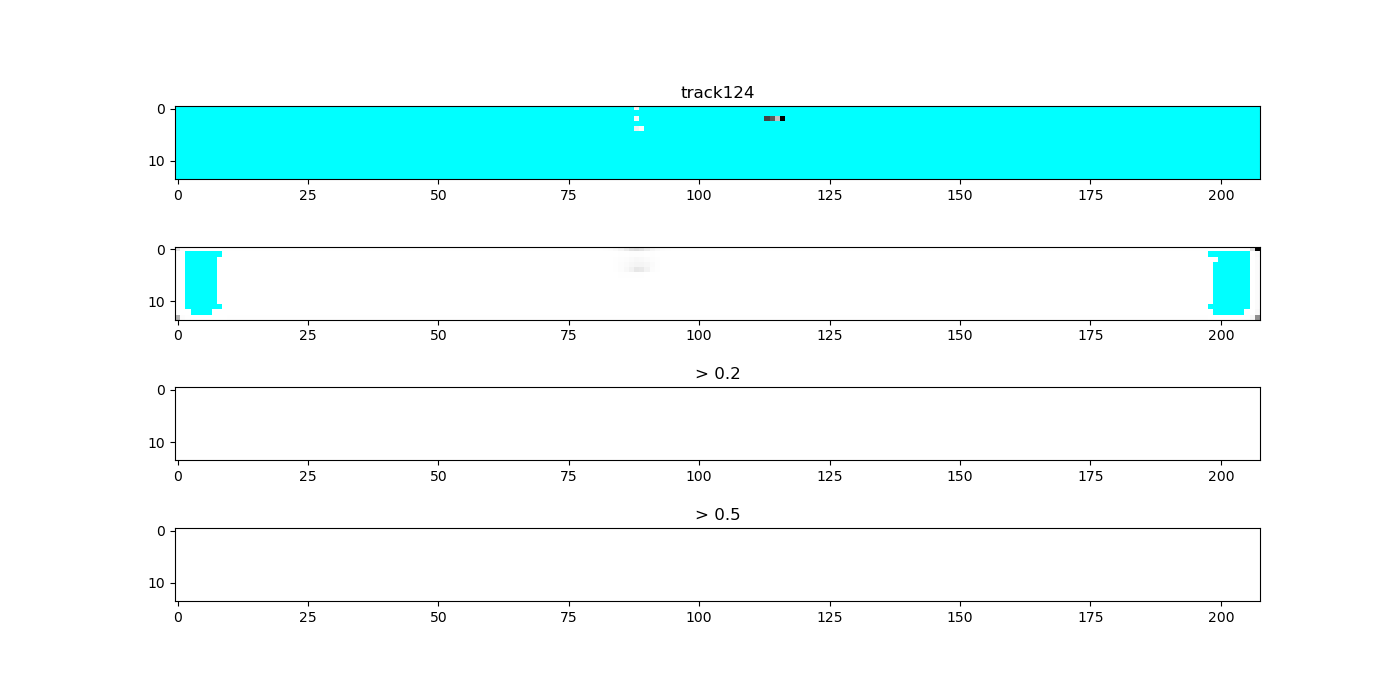

In [114]:
#Show reconstruction
modelAPI.threshold = 0.5
classified = modelAPI.classify(reconstruction)

axis = 0
index = numpy.random.randint(0, 250)

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(4)
cmap = matplotlib.pyplot.get_cmap("Greys")
cmap.set_under('cyan')
eps = 1e-6
ax[0].imshow(numpy.sum(noisy[index], axis), cmap, vmin=numpy.min([eps, numpy.max(noisy[index])]))
ax[1].imshow(numpy.sum(reconstruction[index], axis), cmap, vmin=numpy.min([eps, numpy.max(reconstruction[index])]))
ax[2].imshow(numpy.sum(numpy.where(reconstruction[index] > 0.2, 1, 0), axis), cmap, vmin=numpy.min([eps, numpy.max(classified[index])]))
ax[3].imshow(numpy.sum(numpy.where(reconstruction[index] > 0.5, 1, 0), axis), cmap, vmin=numpy.min([eps, numpy.max(classified[index])]))
ax[0].set_title(names[index])
ax[2].set_title("> 0.2")
ax[3].set_title("> 0.5")
fig.set_size_inches(14, 7)